In [16]:
import warnings
warnings.filterwarnings('ignore')
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.svm import SVC, LinearSVC
from datetime import datetime
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, ADASYN 
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier,HistGradientBoostingClassifier, StackingClassifier
from lightgbm import LGBMClassifier
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression, Lasso, RidgeCV, SGDClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA, KernelPCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from joblib import dump, load
import json
import glob
import os
import pandas as pd
import time;
from utils.data import *
from utils.evaluation import *
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))


df = pd.read_csv("ntu-fintech-hw1-new/train.csv", index_col=["index"])
df.head(1)

,age,euducation_level,job,marital,have_credit_card,have_housing_loan,have_personal_loan,connect_method,previous_connect_month,previous_connect_weekday,campaign_connect_times,after_campaign_connect_day,before_campaign_connect_times,last_campaign_outcomes,employment_rate,consumer_price_index,consumer_confidence_index,label
index,,,,,,,,,,,,,,,,,,
0,39.0,high,employment,married,no,no,no,cellular,November,Tuesday,1.0,-1.0,0.0,nonexistent,59.9,93.2,-42.0,0


In [17]:
df = df.fillna(df.rolling(2, min_periods=1).sum().mean())
for feature in df.columns:
    df[feature] = labelencoder.fit_transform(df[feature])
X = df.drop(['label'],axis=1)
y = df['label']
print(X.shape, y.shape)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.7)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
X_train.head(1)

(20000, 17) (20000,)
(6000, 17) (14000, 17) (6000,) (14000,)


,age,euducation_level,job,marital,have_credit_card,have_housing_loan,have_personal_loan,connect_method,previous_connect_month,previous_connect_weekday,campaign_connect_times,after_campaign_connect_day,before_campaign_connect_times,last_campaign_outcomes,employment_rate,consumer_price_index,consumer_confidence_index
index,,,,,,,,,,,,,,,,,
9882,21,2,0,1,0,2,0,0,7,3,0,1,0,1,7,11,7


Fitting 3 folds for each of 30 candidates, totalling 90 fits
{'memory': None, 'steps': [('sampling', RandomUnderSampler()), ('scaler', StandardScaler()), ('GradientBoostingClassifier', GradientBoostingClassifier(criterion='mse', learning_rate=0.06555172413793103,
                           loss='exponential', max_depth=2, max_features='sqrt',
                           min_samples_leaf=5, min_samples_split=7))], 'verbose': False, 'sampling': RandomUnderSampler(), 'scaler': StandardScaler(), 'GradientBoostingClassifier': GradientBoostingClassifier(criterion='mse', learning_rate=0.06555172413793103,
                           loss='exponential', max_depth=2, max_features='sqrt',
                           min_samples_leaf=5, min_samples_split=7), 'sampling__random_state': None, 'sampling__replacement': False, 'sampling__sampling_strategy': 'auto', 'scaler__copy': True, 'scaler__with_mean': True, 'scaler__with_std': True, 'GradientBoostingClassifier__ccp_alpha': 0.0, 'GradientBoostingClas

[09:50:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[09:50:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:50:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then b

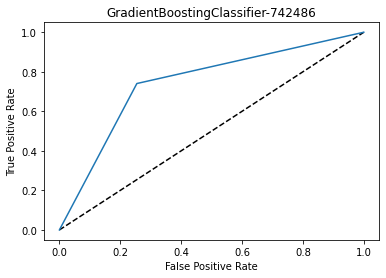

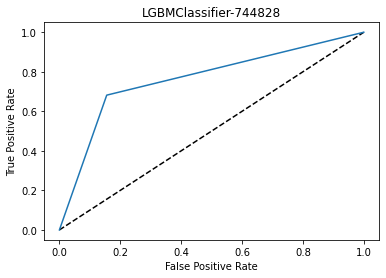

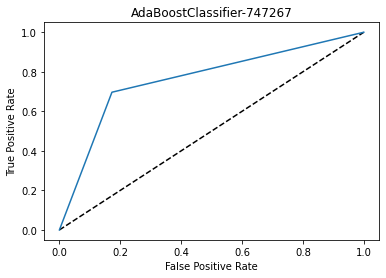

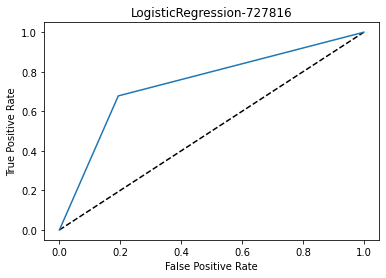

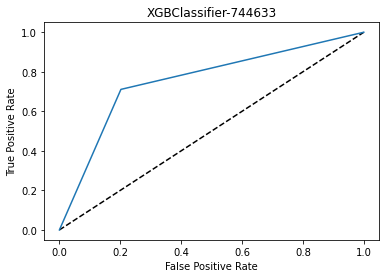

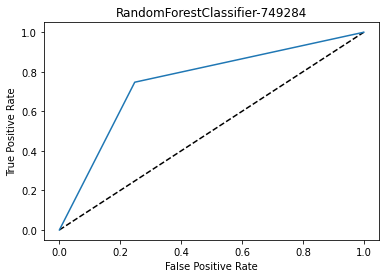

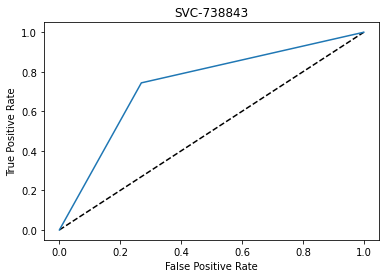

In [31]:

save_folder = str(time.time()).split(".")[0]
os.mkdir("output/models/"+save_folder)
os.mkdir("log/"+save_folder)
os.mkdir("log/"+save_folder+"/img/")
os.mkdir("log/"+save_folder+"/params/")
folds = 3
param_comb = 30


scores = []
save_models = []

for i in range(len(models)):
    save_name = ""
    model_name = str(models[i]).split("(")[0]
    
    
    plt.figure()
    
    pipe = Pipeline(steps=[
                        
                        ('sampling', RandomUnderSampler()), #('sampling', ADASYN()),
                        
                        ('scaler', StandardScaler()),
                        (model_name, models[i])
                        ])
    
    skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)
    random_search = RandomizedSearchCV(pipe, param_distributions=params[i], n_iter=param_comb, scoring='roc_auc', n_jobs=-1, cv=skf.split(X_train,y_train), verbose=3, random_state=1001 )
    random_search.fit(X_train, y_train)
    model = random_search.best_estimator_
    save_models.append(model)
    print(model.get_params())
    y_pred = model.predict(X_test)
    score = myScore(y_pred, y_test.to_numpy()) 
    save_name = model_name+"-"+str(score)[2:8]
    scores.append(score)
    cm ,report, cv_score, roc = result(model, X_test, y_test, y_pred)
    save = {}
    save["myScore"] = score
    save["cm"] = str(cm)
    save["report"] = report
    save["cv_score"] = cv_score
    save["roc"] = roc
    
    
    
    print(save_name)
    dump(model, "output/models/"+save_folder+"/"+save_name+".joblib") 
    with open("log/"+save_folder+"/"+save_name+'.json', 'w') as fp:
        json.dump(save, fp)
    with open("log/"+save_folder+"/params/"+save_name+'.txt', 'w') as fp:
        fp.write(str(model))
    plt.title(save_name)
    plt.savefig("log/"+save_folder+"/img/"+save_name+'.png')

In [35]:
save_models[1]

Pipeline(steps=[('sampling', RandomUnderSampler()),
                ('scaler', StandardScaler()),
                ('LGBMClassifier',
                 LGBMClassifier(colsample_bytree=0.5252010149451318,
                                min_child_samples=116, min_child_weight=0.0001,
                                num_leaves=38, reg_alpha=4, reg_lambda=15,
                                subsample=0.15555555555555556))])

In [81]:
models = [
    MLPClassifier(),
]
params = [
     {'MLPClassifier__solver': ['lbfgs'], 
      'MLPClassifier__max_iter': [1000,1100,1200,1300,1400,1500,1600,1700,1800,1900,2000 ], 
      'MLPClassifier__alpha': 10.0 ** -np.arange(1, 10), 
      'MLPClassifier__hidden_layer_sizes':np.arange(5, 40), 
      'MLPClassifier__learning_rate': ["adaptive", "constant"],
      'MLPClassifier__early_stopping':[True]
     }

]

In [96]:
models = [
    XGBClassifier(),
    SVC(),
    RandomForestClassifier(),
    LogisticRegression(),
    LGBMClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    HistGradientBoostingClassifier(),
    SGDClassifier(),
    MLPClassifier()
]
params = [
    {},
    {},
    {},
    {},
    {},
    {},
    {},
    {},
    {},
    {},
]

In [49]:
np.linspace(0.1, 0.5, 12)

array([0.1       , 0.13636364, 0.17272727, 0.20909091, 0.24545455,
       0.28181818, 0.31818182, 0.35454545, 0.39090909, 0.42727273,
       0.46363636, 0.5       ])

In [30]:
models = [
    GradientBoostingClassifier(),
    LGBMClassifier(),
    AdaBoostClassifier(),
    LogisticRegression(),
    XGBClassifier(),
    RandomForestClassifier(),
    SVC()
]
params = [
     {
        "GradientBoostingClassifier__loss":["deviance", "exponential"],
        "GradientBoostingClassifier__learning_rate": np.linspace(1e-4,1e-1,30),
        "GradientBoostingClassifier__min_samples_split": [2,3,5,7],
        "GradientBoostingClassifier__min_samples_leaf": [1,3,5],
        "GradientBoostingClassifier__max_depth":[2, 3,5,8],
        "GradientBoostingClassifier__max_features":["log2","sqrt", "None"],
        "GradientBoostingClassifier__criterion": ["friedman_mse", "squared_error", "mse", "mae"],
        "GradientBoostingClassifier__subsample":[0.2, 0.3, 0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
        "GradientBoostingClassifier__n_estimators":[50,100,150,200,300]
    },
    {'LGBMClassifier__num_leaves': sp_randint(6, 50), 
             'LGBMClassifier__min_child_samples': np.linspace(90,150,10).astype("int"),#sp_randint(100, 500), 
             'LGBMClassifier__min_child_weight': [1e-7, 1e-4, 1e-5, 1e-3],
             'LGBMClassifier__subsample': np.linspace(0.1,0.6,10), 
             'LGBMClassifier__colsample_bytree': sp_uniform(loc=0.5, scale=0.6),
             'LGBMClassifier__reg_alpha': [0,1,2,3,4,5],
             'LGBMClassifier__reg_lambda': [10,15,20,25,30]
    },
    {'AdaBoostClassifier__n_estimators':[500, 1000, 1500, 2000], 
            'AdaBoostClassifier__learning_rate':np.linspace(1e-5,1e-1,10)
    },
    {"LogisticRegression__C":np.logspace(-3,3,7), 
     "LogisticRegression__penalty":["l1","l2"]
    },
    {
        'XGBClassifier__min_child_weight': np.linspace(1e-2,1e2,10),
        'XGBClassifier__gamma': [0.01, 0.25, 0.5, 1, 1.25, 1.5, 2,3],
        'XGBClassifier__subsample': np.linspace(0.2,1,10),
        'XGBClassifier__colsample_bytree': np.linspace(0.2,1,10),
        'XGBClassifier__max_depth': [2, 3, 4, 5, 6, 7,8],
        'XGBClassifier__early_stopping_rounds':[10,15,20, 30],
        'XGBClassifier__eta':[2,1.5, 1,0.75,0.5,0.25, 0.01],
        'XGBClassifier__n_estimators':np.linspace(100,500,20).astype("int")
    },
    { 
    'RandomForestClassifier__n_estimators': [100, 200,300, 500,1000],
    'RandomForestClassifier__max_features': ['auto', 'sqrt', 'log2'],
    'RandomForestClassifier__max_depth' : [2,3,5,7],
    'RandomForestClassifier__criterion' :['gini', 'entropy']
    },
    {'SVC__kernel':['rbf'],
              'SVC__C':np.linspace(1e-3, 1e5, 10), 
              'SVC__gamma':np.linspace(1e-5,0.5, 5),
             'SVC__probability':[True],
    }
    
]

In [21]:
models[0].split()

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None)